In [115]:
### TODO
### Fix the plotting of the map 

from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
hrrr = Herbie(
    "2025-09-25 12:00", 
    model="hrrr", 
    product="sfc", 
    fxx=6
)

rtma = Herbie("2025-09-25 18:00", 
           model="rtma", 
           product="anl"
)

In [ ]:
ds_hrrr = hrrr.xarray("TMP:2 m above")
ds_hrrr

In [ ]:
ds_rtma = rtma.xarray("TMP:2 m above")
ds_rtma

In [ ]:
ds_rtma = ds_rtma.assign_coords(x=ds_rtma.x, y=ds_rtma.y)
ds_hrrr = ds_hrrr.assign_coords(x=ds_hrrr.x, y=ds_hrrr.y)

rtma_on_hrrr = ds_rtma.interp_like(ds_hrrr)
###tempdiff = rtma_on_hrrr.t2m - ds_hrrr.t2m

In [ ]:
# 2) ensure dims align (y,x)
###tempdiff = tempdiff.transpose("y", "x")

In [ ]:
rtma_on_hrrr.sizes["x"] == ds_hrrr.sizes["x"]  # -> 1799

In [ ]:
rtma_on_hrrr.sizes["y"] == ds_hrrr.sizes["y"]  # -> 1059

In [ ]:
rtma_on_hrrr = rtma_on_hrrr.assign_coords(
    latitude=ds_hrrr.latitude,
    longitude=ds_hrrr.longitude,
)

In [ ]:
rtma_on_hrrr["latitude"] == ds_hrrr["latitude"]  # -> True

In [ ]:
rtma_on_hrrr["longitude"] == ds_hrrr["longitude"]  #-> True

In [ ]:
print(ds_hrrr.x.attrs.get("units"), ds_hrrr.y.attrs.get("units"))
print(ds_rtma.herbie.crs)

In [ ]:
"""
ax = EasyMap("50m", crs=rtma_on_hrrr.herbie.crs, figsize=[10, 8]).BORDERS().STATES().ax

p = ax.pcolormesh(
    rtma_on_hrrr["longitude"],
    rtma_on_hrrr["latitude"],
    rtma_on_hrrr.t2m - 273.15,
    shading="nearest",
    transform=pc,
    **paint.NWSTemperature.kwargs2,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **paint.NWSTemperature.cbar_kwargs2,
)

ax.set_title(
    f"{rtma_on_hrrr.model.upper()}: {rtma.product_description}\nValid: {rtma_on_hrrr.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds_rtma.t2m.GRIB_name, loc="right")
"""

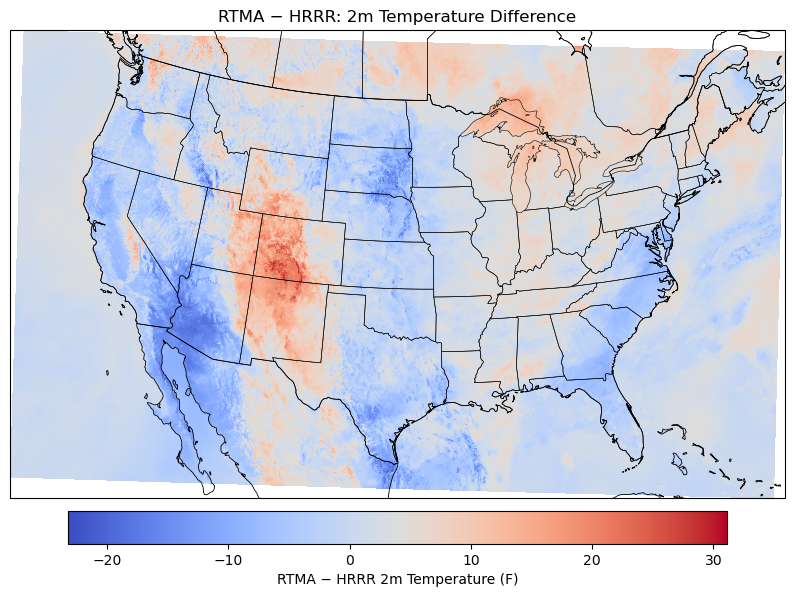

In [123]:
# 1) Compute difference on HRRR grid (assumes you've already done interp_like)
diff = (rtma_on_hrrr.t2m - ds_hrrr.t2m).transpose("y", "x")  # ensure (y,x)

# 2) Use HRRR lon/lat + wrap
lon = ds_hrrr["longitude"]
lat = ds_hrrr["latitude"]
lon = xr.where(lon > 180, lon - 360, lon)

# 3) Make a Cartopy map (no EasyMap)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-95))  # pick your map proj
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.coastlines(resolution="50m", linewidth=0.6)

# 4) Plot (coordinates are lon/lat centers)
pc = ccrs.PlateCarree()
p = ax.pcolormesh(
    lon, lat, diff,
    cmap="coolwarm",
    transform=pc,         # data coords
    shading="nearest"     # treat lon/lat as cell centers
)

cb = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.02, shrink=0.85)
cb.set_label("RTMA − HRRR 2m Temperature (F)")
ax.set_title("RTMA − HRRR: 2m Temperature Difference")
plt.show()
